# BBC Text MultiClass Classification

In [1]:
# load packages
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import decomposition, ensemble
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas, xgboost, numpy, string
import pandas as pd

C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [17]:
# load the dataset
# trainDF = pd.read_csv('../input/bbc-text.csv') # encoding = "latin"
other_stop_w = pd.read_csv('words_shared_by_all.csv')
import re
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Every dataset is lower cased except for TREC
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r",", " ", string) 
    string = re.sub(r"!", " ", string) 
    string = re.sub(r"\(", " ", string) 
    string = re.sub(r"\)", " ", string) 
    string = re.sub(r"\?", " ", string) 
    string = re.sub(r"\s{2,}", " ", string)   
    string = re.sub(" \d+", " ", string)
    return  string.strip().lower()

TRAIN_FILEPATH = "../Translated/cleaned/train.csv"
TEST_FILEPATH = "../Translated/cleaned/test.csv"
SS_FILEPATH = "../data/SampleSubmission.csv"
VECTORS_FILEPATH = ""
trainDF = pd.read_csv(TRAIN_FILEPATH)
test = pd.read_csv(TEST_FILEPATH)
ss = pd.read_csv(SS_FILEPATH)
trainDF["Text"] =trainDF.Text.apply(lambda x: clean_str(x))
test["Text"] =test.Text.apply(lambda x: clean_str(x))
import tqdm
stopw = [item for sublist in other_stop_w.values.tolist() for item in sublist]
trainDF['Text'].apply(lambda x: [item for item in x.split() if item not in stopw]) 
test['Text'].apply(lambda x: [item for item in x.split() if item not in stopw]) 

0      [abambo, odzikhweza, akuchuluka, kafukufuku, a...
1      [ambuye, ziyaye, ayamikira, aphunzitsi, tilito...
2      [anatcheleza, akundiopseza, gogo, wanga, akund...
3      [ulova, wafika, posauzana, adatenga, digiri, u...
4      [dzombe, kukoma, kuyambira, makedzana, panthaw...
                             ...                        
615    [kanyongolo, wapempha, oyimira, milandu, atsat...
616    [amandimenya, zikomo, gogo, ndine, mtsikana, z...
617    [apolisi, athotha, gulu, myp, asilikali, gulu,...
618    [mwambo, ukwati, chitonga, mtundu, wina, uliwo...
619    [mwapasa, autsa, mapiri, kusamvana, pakati, ap...
Name: Text, Length: 620, dtype: object

In [22]:
# trainDF.head(10)
# [other_stop_w.values.tolist()]
# pd.read_csv(TEST_FILEPATH).Text[0]

In [23]:
trainDF.shape

(1436, 3)

In [24]:
trainDF['Label'].unique()

array(['POLITICS', 'HEALTH', 'LAW/ORDER', 'RELIGION', 'FARMING',
       'WILDLIFE/ENVIRONMENT', 'SOCIAL ISSUES', 'SOCIAL', 'OPINION/ESSAY',
       'LOCALCHIEFS', 'WITCHCRAFT', 'ECONOMY', 'SPORTS', 'RELATIONSHIPS',
       'TRANSPORT', 'CULTURE', 'EDUCATION', 'MUSIC', 'ARTS AND CRAFTS',
       'FLOODING'], dtype=object)

In [25]:
trainDF['Label'].value_counts()

POLITICS                279
SOCIAL                  152
RELIGION                147
LAW/ORDER               136
SOCIAL ISSUES           134
HEALTH                  127
ECONOMY                  86
FARMING                  78
SPORTS                   49
EDUCATION                43
RELATIONSHIPS            39
WILDLIFE/ENVIRONMENT     36
OPINION/ESSAY            26
LOCALCHIEFS              25
CULTURE                  23
WITCHCRAFT               16
MUSIC                    15
TRANSPORT                11
ARTS AND CRAFTS           7
FLOODING                  7
Name: Label, dtype: int64

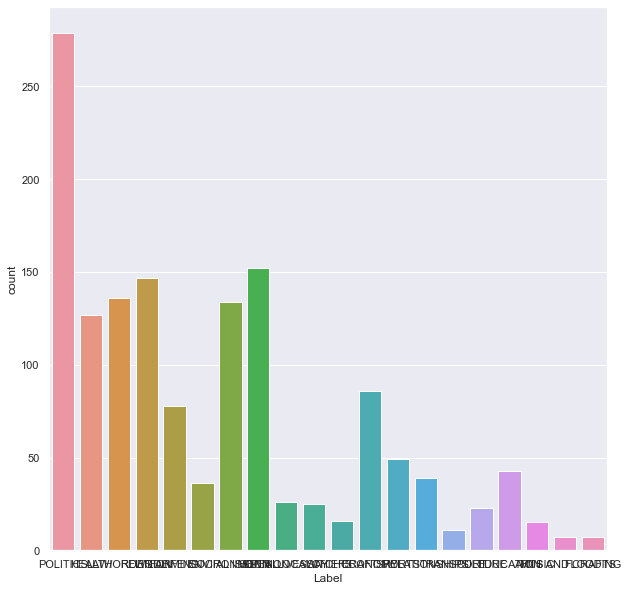

In [26]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(trainDF['Label'])

## Data preparation

In [27]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['Text'], trainDF['Label'])

train_labels = train_y
valid_labels = valid_y
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

## Feature Extraction

### Count Vectors

In [28]:
# Count Vectors as features
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['Text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

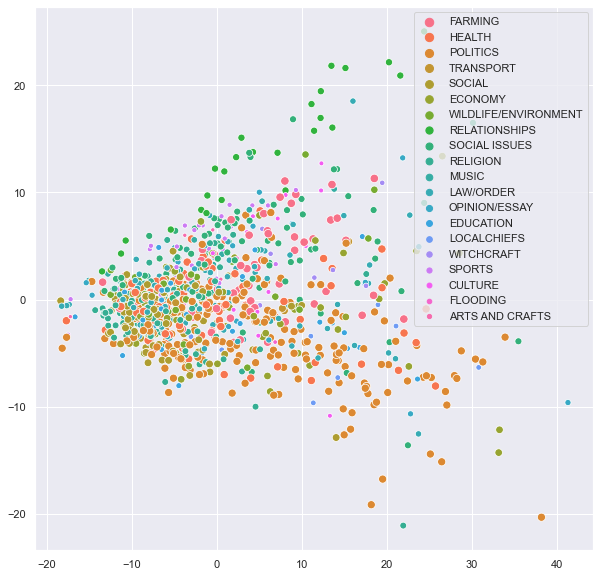

In [29]:
# plot the train features
pca = PCA(n_components=2).fit(xtrain_count.toarray())
data2D = pca.transform(xtrain_count.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=train_labels.tolist(),size=train_labels.tolist(),palette="husl")

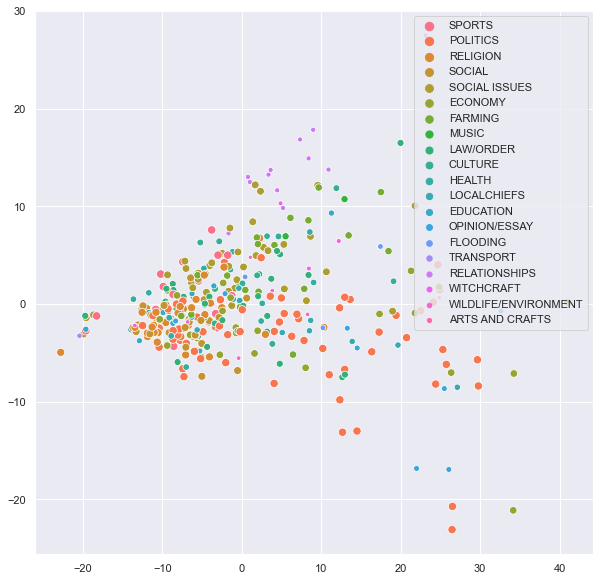

In [30]:
# plot the validation features
pca = PCA(n_components=2).fit(xvalid_count.toarray())
data2D = pca.transform(xvalid_count.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=valid_labels.tolist(),size=valid_labels.tolist(),palette="husl")

###  TF-IDF Vectors

 TF-IDF Vectors as features
 
 a. Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents
 
 b. N-gram Level TF-IDF : N-grams are the combination of N terms together. This Matrix representing tf-idf scores  of N-grams
 
 c. Character Level TF-IDF : Matrix representing tf-idf scores of character level n-grams in the corpus

### word level tf-idf

In [31]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=1800)
tfidf_vect.fit(trainDF['Text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

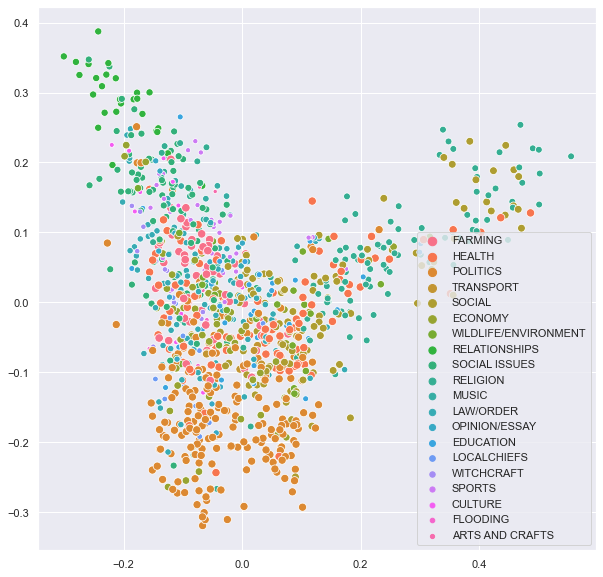

In [32]:
# plot the train features
pca = PCA(n_components=2).fit(xtrain_tfidf.toarray())
data2D = pca.transform(xtrain_tfidf.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=train_labels.tolist(),size=train_labels.tolist(),palette="husl")

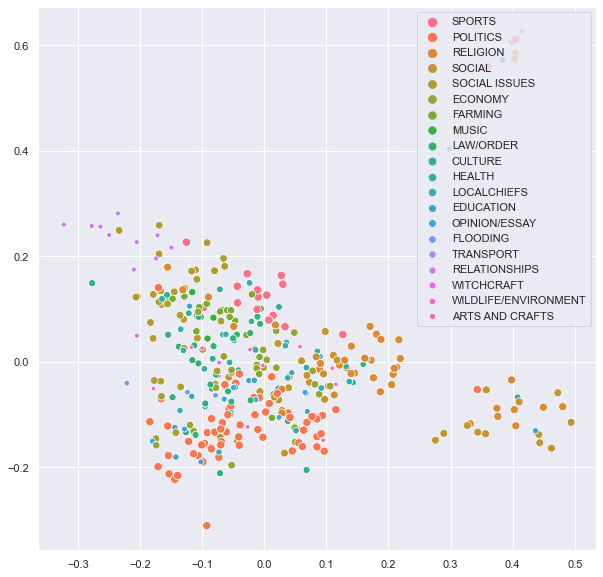

In [33]:
# plot the validation features
pca = PCA(n_components=2).fit(xvalid_tfidf.toarray())
data2D = pca.transform(xvalid_tfidf.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=valid_labels.tolist(),size=valid_labels.tolist(),palette="husl")

### ngram level tf-idf 

In [34]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,4), max_features=1800)
tfidf_vect_ngram.fit(trainDF['Text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

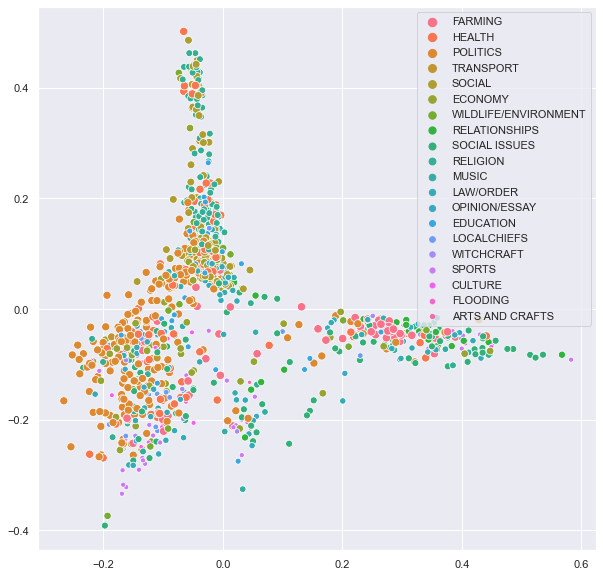

In [35]:
# plot the train features
pca = PCA(n_components=2).fit(xtrain_tfidf_ngram.toarray())
data2D = pca.transform(xtrain_tfidf_ngram.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=train_labels.tolist(),size=train_labels.tolist(),palette="husl")

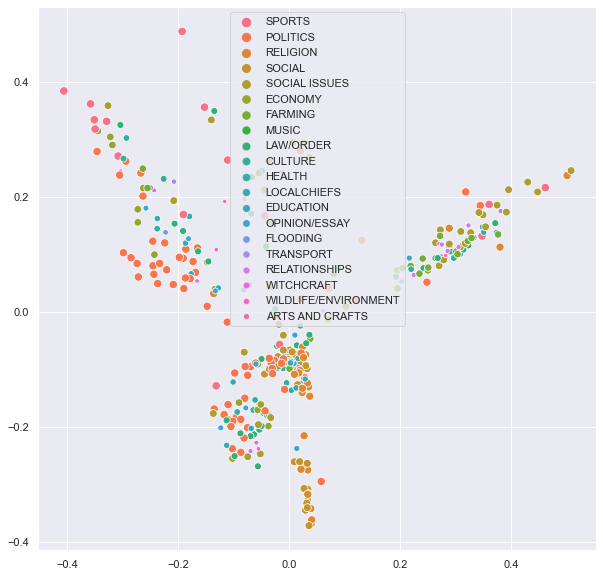

In [36]:
# plot the validation features
pca = PCA(n_components=2).fit(xvalid_tfidf_ngram.toarray())
data2D = pca.transform(xvalid_tfidf_ngram.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=valid_labels.tolist(),size=valid_labels.tolist(),palette="husl")

### characters level tf-idf

In [37]:
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=1800)
tfidf_vect_ngram_chars.fit(trainDF['Text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:501: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


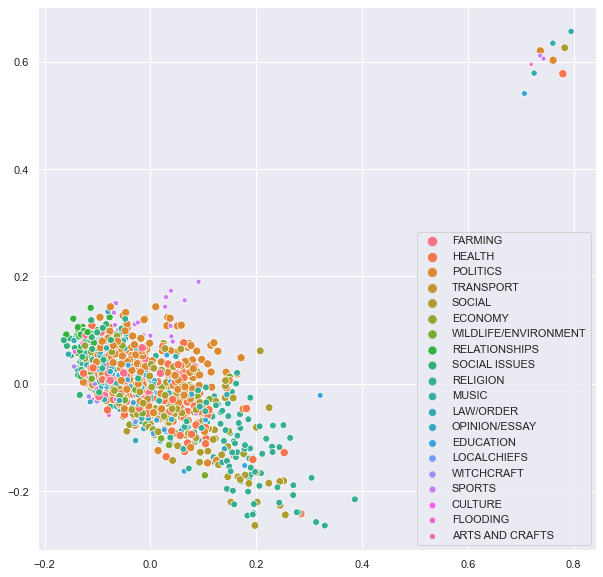

In [38]:
# plot the train features
pca = PCA(n_components=2).fit(xtrain_tfidf_ngram_chars.toarray())
data2D = pca.transform(xtrain_tfidf_ngram_chars.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=train_labels.tolist(),size=train_labels.tolist(),palette="husl")

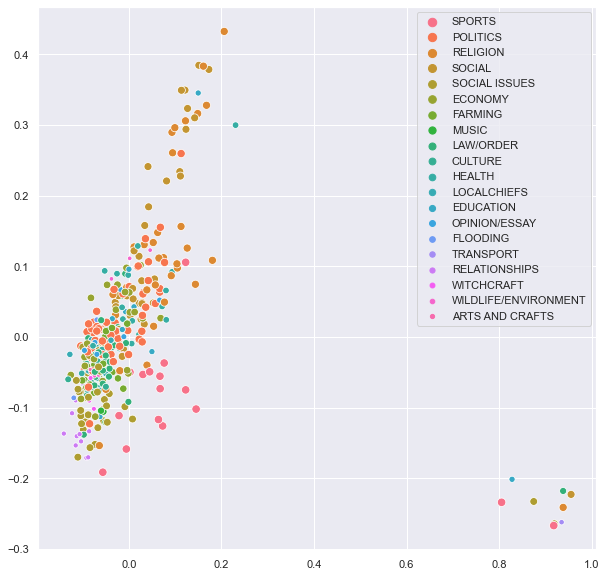

In [39]:
# plot the validation features
pca = PCA(n_components=2).fit(xvalid_tfidf_ngram_chars.toarray())
data2D = pca.transform(xvalid_tfidf_ngram_chars.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=valid_labels.tolist(),size=valid_labels.tolist(),palette="husl")

### HashingVectorizer

In [40]:
# getting train features
hash_vectorizer = HashingVectorizer(n_features=1800)
hash_vectorizer.fit(trainDF['Text'])
xtrain_hash_vectorizer =  hash_vectorizer.transform(train_x) 
xvalid_hash_vectorizer =  hash_vectorizer.transform(valid_x)

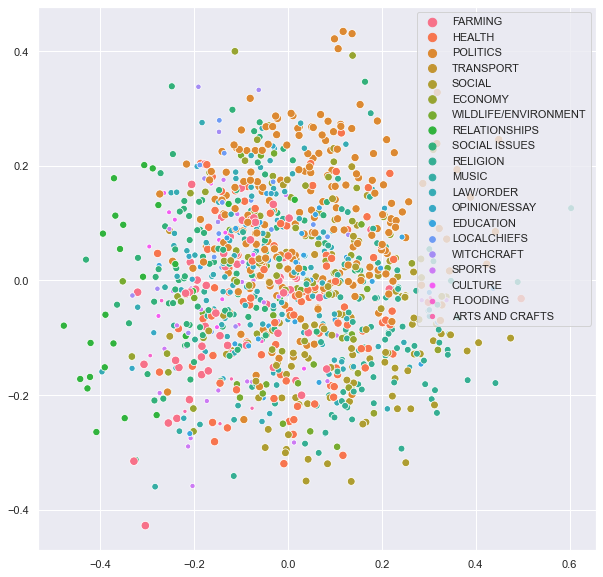

In [41]:
# plot the train features
pca = PCA(n_components=2).fit(xtrain_hash_vectorizer.toarray())
data2D = pca.transform(xtrain_hash_vectorizer.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=train_labels.tolist(),size=train_labels.tolist(),palette="husl")

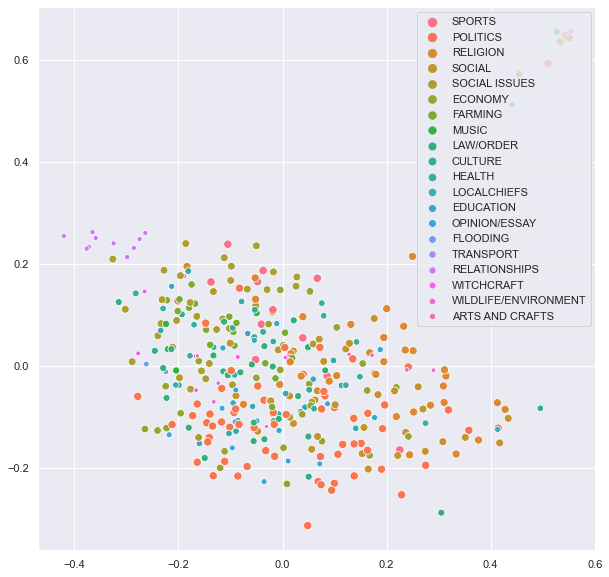

In [42]:
# plot the validation features
pca = PCA(n_components=2).fit(xvalid_hash_vectorizer.toarray())
data2D = pca.transform(xvalid_hash_vectorizer.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=valid_labels.tolist(),size=valid_labels.tolist(),palette="husl")

## Model Building

In [43]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

### Naive Bayes

In [44]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.4735376044568245
NB, WordLevel TF-IDF:  0.46518105849582175
NB, N-Gram Vectors:  0.4401114206128134
NB, CharLevel Vectors:  0.22284122562674094


### Linear Classifier

In [45]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("LR, CharLevel Vectors: ", accuracy)

# Linear Classifier on Hash Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("LR, Hash Vectors: ", accuracy)

LR, Count Vectors:  0.6211699164345403
LR, WordLevel TF-IDF:  0.5793871866295265
LR, N-Gram Vectors:  0.5236768802228412
LR, CharLevel Vectors:  0.5069637883008357
LR, Hash Vectors:  0.5236768802228412


### RandomForestClassifier

In [47]:
# RF on Count Vectors
n_estimators = 1000
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=n_estimators), xtrain_count, train_y, xvalid_count)
print("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=n_estimators), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", accuracy)

# RF on Ngram Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=n_estimators), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("RF, N-Gram Vectors: ", accuracy)

# RF on Character Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=n_estimators), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("RF, CharLevel Vectors: ", accuracy)

# RF on Hash Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=n_estimators), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("RF, Hash Vectors: ", accuracy)

RF, Count Vectors:  0.5292479108635098
RF, WordLevel TF-IDF:  0.5598885793871866
RF, N-Gram Vectors:  0.4596100278551532
RF, CharLevel Vectors:  0.5515320334261838
RF, Hash Vectors:  0.532033426183844


### Extreme Gradient Boosting

In [ ]:
# Extreme Gradient Boosting on Count Vector
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print("Xgb, Count Vectors: ", accuracy)

# Extreme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ", accuracy)

# Extreme Gradient Boosting on Ngram Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Xgb, N-Gram Vectors: ", accuracy)

# Extreme Gradient Boosting on Character Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print("Xgb, CharLevel Vectors: ", accuracy)

# Extreme Gradient Boosting on Hash Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("Xgb, Hash Vectors: ", accuracy)